In [21]:
!pip install pycryptodome pillow


In [22]:
from PIL import Image
from Crypto.Cipher import DES
from Crypto.Protocol.KDF import scrypt
import numpy as np
import os
import getpass
from IPython.display import display
from google.colab import files


In [23]:
def image_to_bytes(image_path):
    image = Image.open(image_path).convert('RGB')
    pixels = np.array(image)
    return pixels.tobytes(), image.size


In [24]:
def bytes_to_image(image_bytes, image_size):
    array = np.frombuffer(image_bytes, dtype=np.uint8)[:image_size[0] * image_size[1] * 3]
    array = array.reshape((image_size[1], image_size[0], 3))
    return Image.fromarray(array)


In [25]:
def derive_key(password):
    salt = os.urandom(16)
    return scrypt(password.encode(), salt, key_len=8, N=2**14, r=8, p=1), salt


In [26]:
def encrypt_image(image_data, key, mode):
    if mode == 'ECB':
        cipher = DES.new(key, DES.MODE_ECB)
        ciphertext = cipher.encrypt(image_data)
        return ciphertext, None
    elif mode == 'OFB':
        iv = os.urandom(8)
        cipher = DES.new(key, DES.MODE_OFB, iv=iv)
        ciphertext = cipher.encrypt(image_data)
        return ciphertext, iv


In [27]:
def decrypt_image(ciphertext, key, mode, iv=None):
    if mode == 'ECB':
        cipher = DES.new(key, DES.MODE_ECB)
        plaintext = cipher.decrypt(ciphertext)
        return plaintext
    elif mode == 'OFB':
        cipher = DES.new(key, DES.MODE_OFB, iv=iv)
        plaintext = cipher.decrypt(ciphertext)
        return plaintext


In [30]:
def main():
    uploaded = files.upload()
    image_path = next(iter(uploaded))
    image_data, image_size = image_to_bytes(image_path)

    password = getpass.getpass("Enter the password: ")
    key, salt = derive_key(password)
    print(f'key is {key}')

    ## only applying padding to ecb when required
    image_data_ecb = image_data
    padding_length = 8 - (len(image_data_ecb) % 8)
    if padding_length != 8:
        image_data_ecb += b'\0' * padding_length

    ciphertext_ecb, _ = encrypt_image(image_data_ecb, key, 'ECB')
    ecb_image = bytes_to_image(ciphertext_ecb[:len(image_data_ecb)], image_size)

    ciphertext_ofb, iv_ofb = encrypt_image(image_data, key, 'OFB')
    ofb_image = bytes_to_image(ciphertext_ofb[:len(image_data)], image_size)

    print("ECB Encrypted Image:")
    display(ecb_image)
    print("OFB Encrypted Image:")
    display(ofb_image)

    decrypt_password = getpass.getpass("Enter the password to decrypt: ")
    if decrypt_password == password:
        decrypted_ecb = decrypt_image(ciphertext_ecb, key, 'ECB')
        decrypted_ecb_image = bytes_to_image(decrypted_ecb[:len(image_data_ecb)], image_size)

        decrypted_ofb = decrypt_image(ciphertext_ofb, key, 'OFB', iv_ofb)
        decrypted_ofb_image = bytes_to_image(decrypted_ofb[:len(image_data)], image_size)

        print("Decrypted ECB Image:")
        display(decrypted_ecb_image)
        print("Decrypted OFB Image:")
        display(decrypted_ofb_image)
    else:
        print("Incorrect password! Decryption failed.")


Saving sample_input_1_optimized_100.png to sample_input_1_optimized_100 (8).png
Enter the password: ··········
password is b'y\x0b\x9b\xdf\x95\xd1\xc9x'
ECB Encrypted Image:


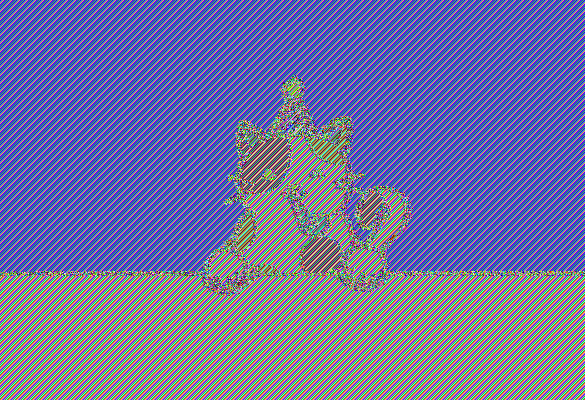

OFB Encrypted Image:


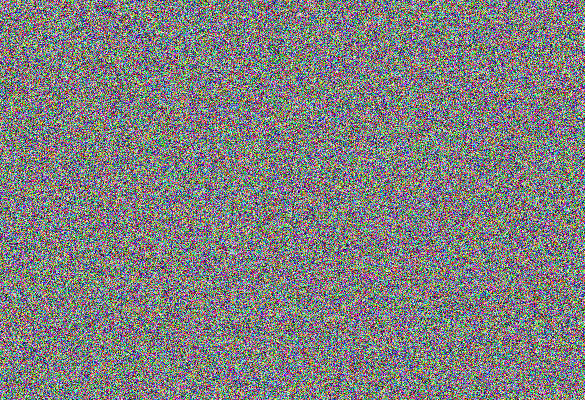

In [ ]:
main()
